In [2]:
import sys

sys.path.append('C:/Users/nilso/Documents/EPFL/PDM/PDM_PINN/SciANN/DNN_TEST/sys/')

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator

import time
import json

from dataloader import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.utils import _quadruple

import cv2
import numpy as np

In [3]:
class FEM_Solver(nn.Module):
    def __init__(self, dh=5, dt=0.002, c=2500, device='cuda:0'):
        super(FEM_Solver, self).__init__()

        # Parameters of the mesh
        self.dh = dh
        self.dt = dt
        self.c = c
        self.device = device

        self.P = (self.dt ** 2) * (self.c ** 2)/(self.dh ** 2)

        # Kernels filters
        # x FD
        self.weight_h = torch.FloatTensor([[[[ 0,  0,  0],[ 1, -2,  1],[ 0,  0,  0]]]]).to(self.device)
        # y FD
        self.weight_v = torch.FloatTensor([[[[ 0,  1,  0],[ 0, -2,  0],[ 0,  1,  0]]]]).to(self.device) 

        self.padding = _quadruple(1)

    def forward(self,inputs):
        """
        inputs : combination of inputs and outputs of the model, shape = (Minibatch,Channels,Width,Height)
        """    

        # TODO : assert length of channels is 4

        self.u_n = inputs[:,-1:,:,:] 
        self.u_n_1 = inputs[:,-2:-1,:,:]

        # Compute derivatives
        self.u_dxdx = F.conv2d(F.pad(self.u_n, self.padding, mode='circular'), self.weight_h, stride=1, padding=0, bias=None)
        self.u_dydy = F.conv2d(F.pad(self.u_n, self.padding, mode='circular'), self.weight_v, stride=1, padding=0, bias=None)

        # Next time step computed based on the finite difference method for the wave equation : 
        next_u = self.P * self.u_dxdx + self.P * self.u_dydy + 2 * self.u_n - self.u_n_1

        return next_u

## Find silent initial conditions

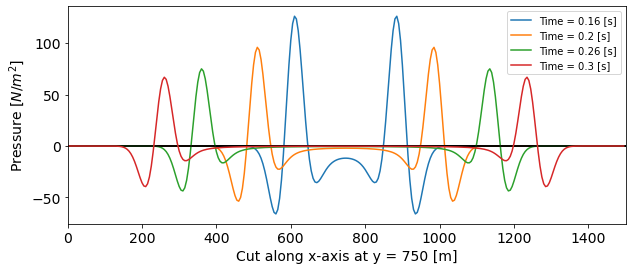

In [4]:
fig, ax = plt.subplots(figsize=(10,4))
for i in [800,1000,1300,1500]:
    ax.plot([0,1500],[0,0],'k')
    ax.plot(list(range(0,1500,5)),cv2.imread(f'Training_Data/Moseley_Homogeneous_Big/Event0000_{i}.tiff',cv2.IMREAD_UNCHANGED)[150,:],label=f'Time = {i*0.0002} [s]')
    ax.set_xlim(0,1500)
    ax.set_xlabel('Cut along x-axis at y = 750 [m]',fontsize = 14)
    ax.set_ylabel('Pressure $[N/m^2]$',fontsize = 14)
    ax.tick_params(axis='both', labelsize=14)

    ax.legend(loc='upper right')
#plt.savefig('Salvus_True.png',dpi=600,bbox_inches='tight')

## Finite difference and Savlus comparison

In [5]:
solver = FEM_Solver(dh=5, dt=0.0002, c=2500)

In [6]:
error_dict = {}

0


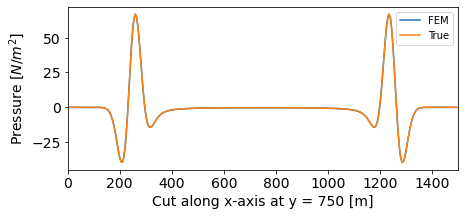

100


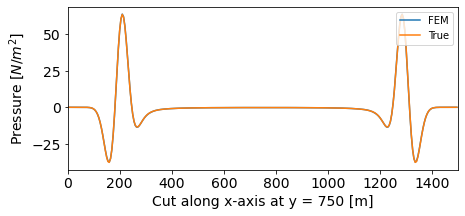

200


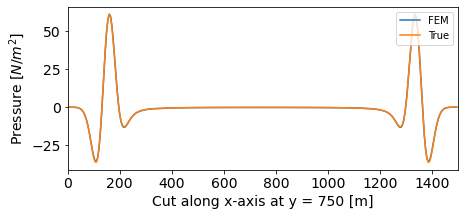

300


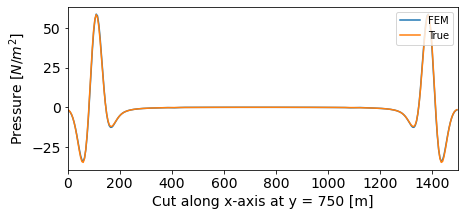

400


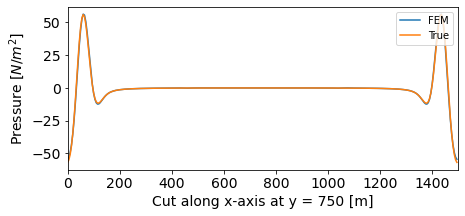

500


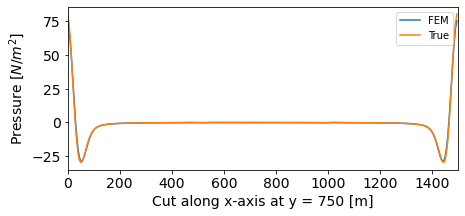

600


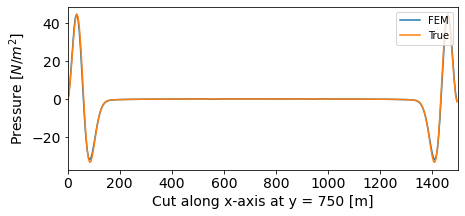

700


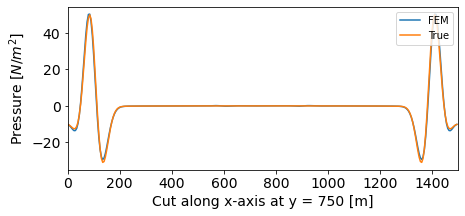

800


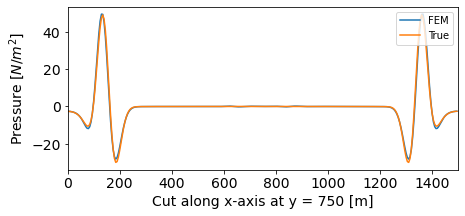

900


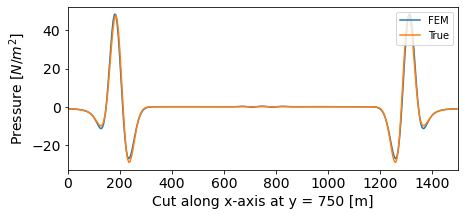

1000


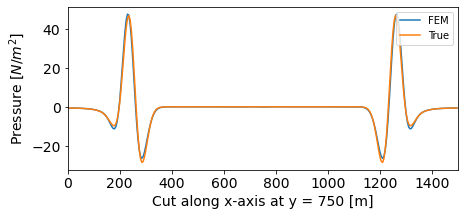

In [7]:
fem_data = dataset('Training_Data/Moseley_Homogeneous_Big/',
                        'Training_Data/Moseley_Homogeneous_Big_FEM_1500.csv',
                        'EVENT0000')
u_0 = fem_data.__getitem__(0)
u_0 = u_0['wave_input'].transpose(1,0)[None]

# Comment to myself : check done, the loaded image from Salvus and predicitons are the same ! 
number_of_timestep_to_predict = 1000

mean_error_rel = []
max_error = []
mean_error = []

for timestep in range(0,number_of_timestep_to_predict+1):
    u_0 = u_0.to(device='cuda:0')

    # Predict next timestep 
    u_next = solver(u_0).detach()
    u_next_cpu = u_next.cpu()

    # Load true Salvus Data
    u_true = fem_data.__getitem__(timestep)['wave_output'].transpose(1,0)[None]

    # Mean absolute relative error 
    error_abs = torch.abs(u_next_cpu - u_true)

    mean_error_rel.append( ( torch.mean( error_abs ) / torch.max(error_abs)).cpu().numpy() )
    max_error.append( ( torch.max(error_abs)  / torch.max(u_true) ).cpu().numpy() )
    mean_error.append( ( torch.mean(error_abs)  / torch.max(u_true) ).cpu().numpy() )

    # Update u_0 with the predictons
    u_0 = torch.cat((u_0[:,1:,:,:].cpu(),u_next.cpu()),dim=1)

    if timestep % 100 == 0:
        print(timestep)

        fig, ax = plt.subplots(figsize=(7,3))
        ax.plot(list(range(0,1500,5)),u_next.cpu().numpy()[0,0][150,:],label='FEM')
        ax.plot(list(range(0,1500,5)),u_true.cpu().numpy()[0,0][150,:],label='True')
        ax.set_xlim(0,1500)
        ax.set_xlabel('Cut along x-axis at y = 750 [m]',fontsize = 14)
        ax.set_ylabel('Pressure $[N/m^2]$',fontsize = 14)
        ax.tick_params(axis='both', labelsize=14)

        plt.legend(loc='upper right')
        #plt.savefig(f'Salvus_vs_FEM_{timestep}.png',dpi=600,bbox_inches='tight')
        plt.show()


error_dict['FEM_1000_mean'] = mean_error_rel
error_dict['FEM_1000_max'] = max_error
error_dict['FEM_1000'] = mean_error

0


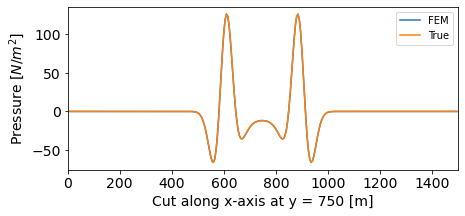

100


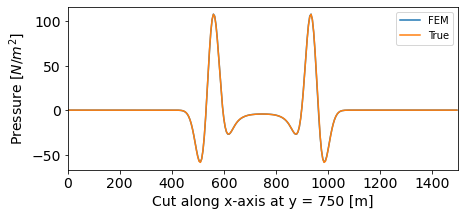

200


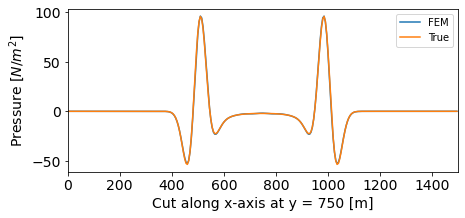

300


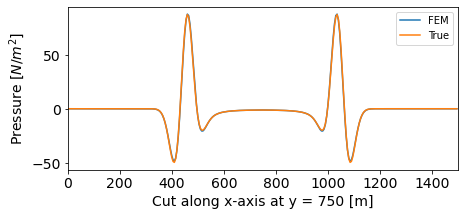

400


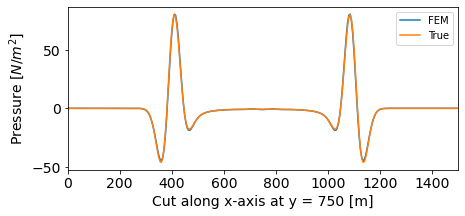

500


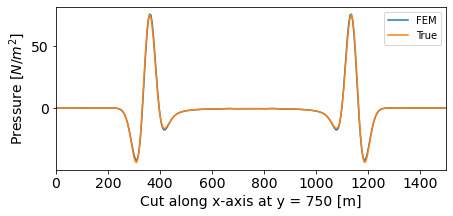

600


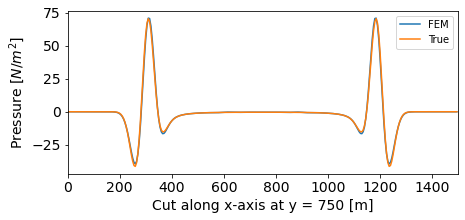

700


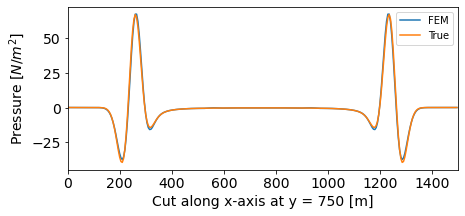

800


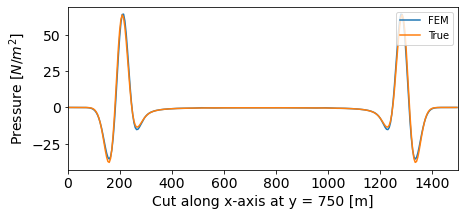

900


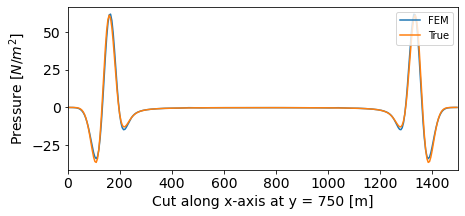

1000


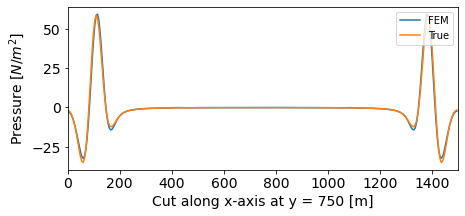

1100


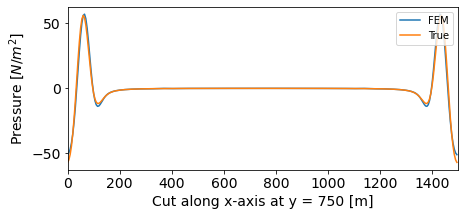

1200


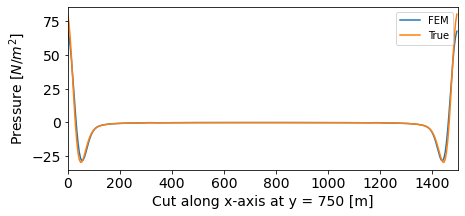

1300


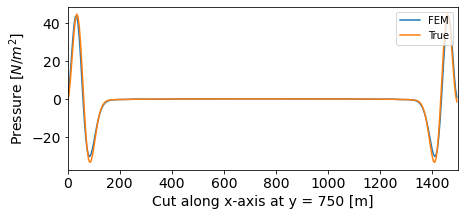

1400


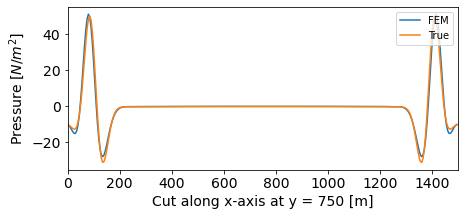

1500


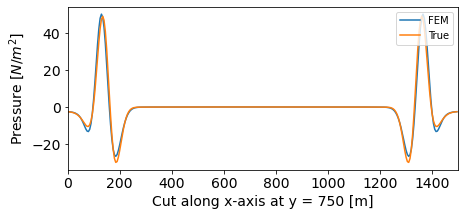

1600


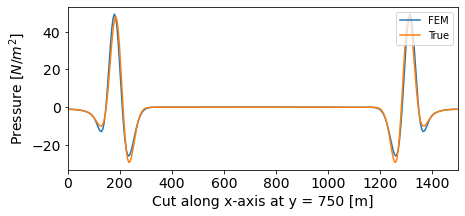

1700


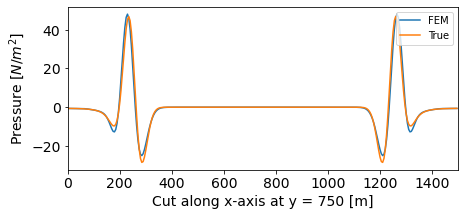

In [8]:
fem_data = dataset('Training_Data/Moseley_Homogeneous_Big/',
                        'Training_Data/Moseley_Homogeneous_Big_FEM_800.csv',
                        'EVENT0000')
u_0 = fem_data.__getitem__(0)
u_0 = u_0['wave_input'].transpose(1,0)[None]

# Comment to myself : check done, the loaded image from Salvus and predicitons are the same ! 
number_of_timestep_to_predict = 1700

mean_error_rel = []
max_error = []
mean_error = []

for timestep in range(0,number_of_timestep_to_predict+1):
    u_0 = u_0.to(device='cuda:0')

    # Predict next timestep 
    u_next = solver(u_0).detach()
    u_next_cpu = u_next.cpu()

    # Load true Salvus Data
    u_true = fem_data.__getitem__(timestep)['wave_output'].transpose(1,0)[None]

    # Mean absolute relative error 
    error_abs = torch.abs(u_next_cpu - u_true)

    mean_error_rel.append( (torch.mean( error_abs ) / torch.max(error_abs)).cpu().numpy() )
    max_error.append( ( torch.max(error_abs)  / torch.max(u_true) ).cpu().numpy() )
    mean_error.append( ( torch.mean(error_abs)  / torch.max(u_true) ).cpu().numpy() )

    # Update u_0 with the predictons
    u_0 = torch.cat((u_0[:,1:,:,:].cpu(),u_next.cpu()),dim=1)

    if timestep % 100 == 0:
        print(timestep)

        fig, ax = plt.subplots(figsize=(7,3))
        ax.plot(list(range(0,1500,5)),u_next.cpu().numpy()[0,0][150,:],label='FEM')
        ax.plot(list(range(0,1500,5)),u_true.cpu().numpy()[0,0][150,:],label='True')
        ax.set_xlim(0,1500)
        ax.set_xlabel('Cut along x-axis at y = 750 [m]',fontsize = 14)
        ax.set_ylabel('Pressure $[N/m^2]$',fontsize = 14)
        ax.tick_params(axis='both', labelsize=14)

        plt.legend(loc='upper right')
        #plt.savefig(f'Salvus_vs_FEM_{timestep}.png',dpi=600,bbox_inches='tight')
        plt.show()

error_dict['FEM_300_mean'] = mean_error_rel
error_dict['FEM_300_max'] = max_error
error_dict['FEM_300'] = mean_error

0


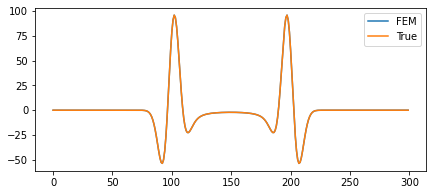

100


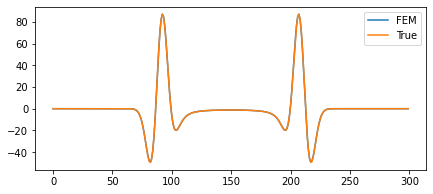

200


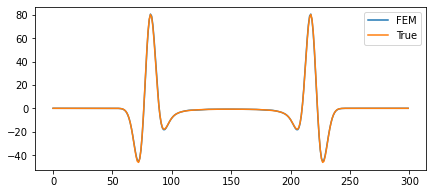

300


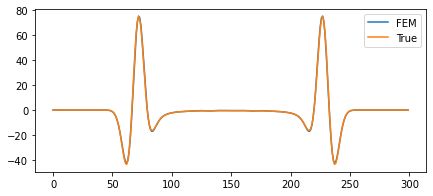

400


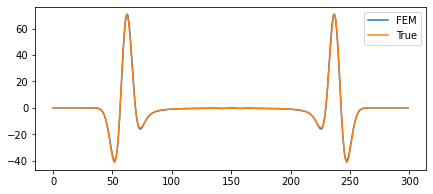

500


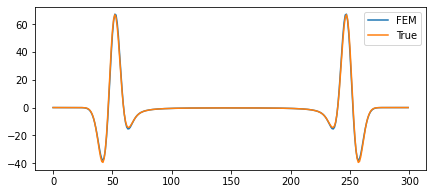

600


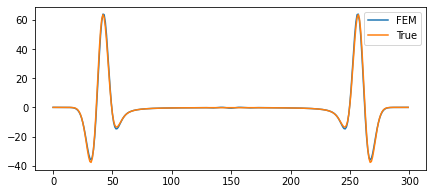

700


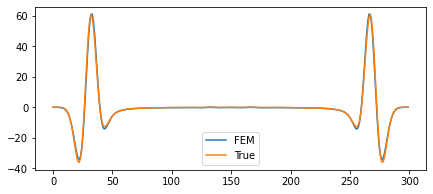

800


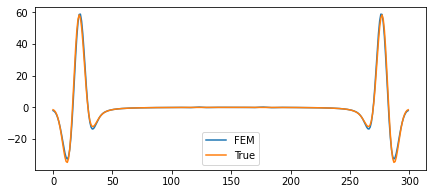

900


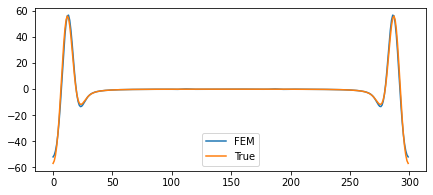

1000


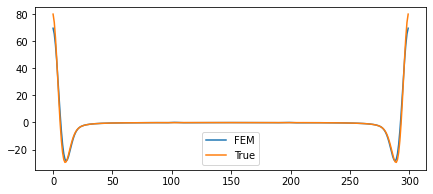

1100


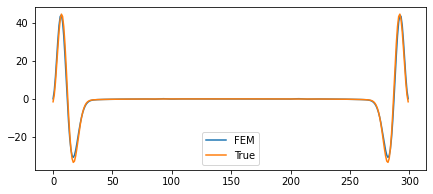

1200


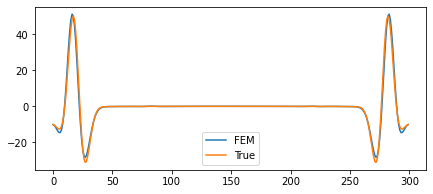

1300


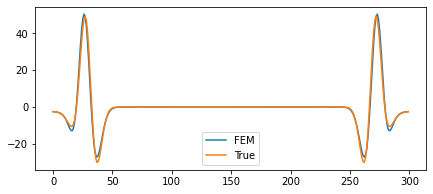

1400


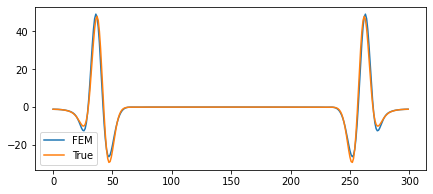

1500


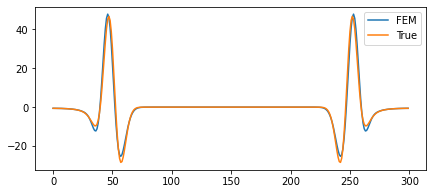

In [9]:
fem_data = dataset('Training_Data/Moseley_Homogeneous_Big/',
                        'Training_Data/Moseley_Homogeneous_Big_FEM_1000.csv',
                        'EVENT0000')
u_0 = fem_data.__getitem__(0)
u_0 = u_0['wave_input'].transpose(1,0)[None]

# Comment to myself : check done, the loaded image from Salvus and predicitons are the same ! 
number_of_timestep_to_predict = 1500

mean_error_rel = []
max_error = []
mean_error = []

for timestep in range(0,number_of_timestep_to_predict+1):
    u_0 = u_0.to(device='cuda:0')

    # Predict next timestep 
    u_next = solver(u_0).detach()

    # Load true Salvus Data
    u_true = fem_data.__getitem__(timestep)['wave_output'].transpose(1,0)[None].to(device='cuda:0')

    # Mean absolute relative error 
    error_abs = torch.abs(u_next - u_true)

    mean_error_rel.append( (torch.mean( error_abs ) / torch.max( error_abs )).cpu().numpy() )
    max_error.append( ( torch.max( error_abs )  / torch.max( u_true ) ).cpu().numpy() )
    mean_error.append( ( torch.mean( error_abs )  / torch.max( u_true ) ).cpu().numpy() )

    # Update u_0 with the predictons
    u_0 = torch.cat((u_0[:,1:,:,:].cpu(),u_next.cpu()),dim=1)

    if timestep % 100 == 0:
        print(timestep)

        fig, ax = plt.subplots(figsize=(7,3))
        ax.plot(u_next.cpu().numpy()[0,0][150,:],label='FEM')
        ax.plot(u_true.cpu().numpy()[0,0][150,:],label='True')
        plt.legend()
        plt.show()

error_dict['FEM_500_mean'] = mean_error_rel
error_dict['FEM_500_max'] = max_error
error_dict['FEM_500'] = mean_error

In [10]:
from matplotlib.lines import Line2D

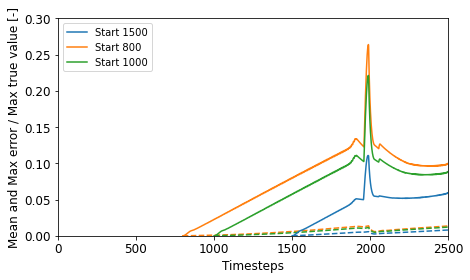

In [11]:
fig, ax = plt.subplots(figsize=(7,4))

ax1, = ax.plot(list(range(1500,2501)),error_dict['FEM_1000'],'--')
ax2, = ax.plot(list(range(800,2501)),error_dict['FEM_300'],'--')
ax3, = ax.plot(list(range(1000,2501)),error_dict['FEM_500'],'--')

ax.plot(list(range(1500,2501)),error_dict['FEM_1000_max'],label=f'Start 1500',color=ax1.get_color())
ax.plot(list(range(800,2501)),error_dict['FEM_300_max'],label=f'Start 800',color=ax2.get_color())
ax.plot(list(range(1000,2501)),error_dict['FEM_500_max'],label=f'Start 1000',color=ax3.get_color())

ax.set_xlim(0,2500)
ax.set_ylim(0,0.3)
ax.yaxis.set_major_locator(MaxNLocator(6)) 
ax.legend(loc='upper left')
ax.set_ylabel('Mean and Max error / Max true value [-]',fontsize=12)
ax.set_xlabel('Timesteps',fontsize=12)
ax.tick_params(axis='both', labelsize=12)
plt.savefig('mean_max_error.png',dpi=600,bbox_inches='tight')

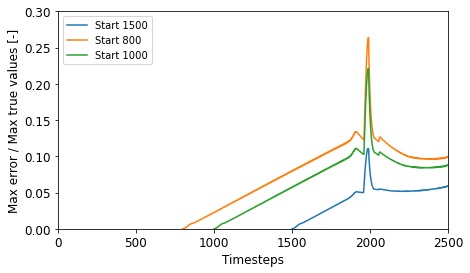

In [12]:
# Ratio between max error and max true values
fig, ax = plt.subplots(figsize=(7,4))

ax.plot(list(range(1500,2501)),error_dict['FEM_1000_max'],label=f'Start 1500')
ax.plot(list(range(800,2501)),error_dict['FEM_300_max'],label=f'Start 800')
ax.plot(list(range(1000,2501)),error_dict['FEM_500_max'],label=f'Start 1000')

ax.set_xlim(0,2500)
ax.set_ylim(0,0.3)
ax.legend(loc='upper left')
ax.set_ylabel('Max error / Max true values [-]',fontsize=12)
ax.set_xlabel('Timesteps',fontsize=12)

ax.tick_params(axis='both', labelsize=12)
plt.savefig('max_error.png',dpi=600,bbox_inches='tight')

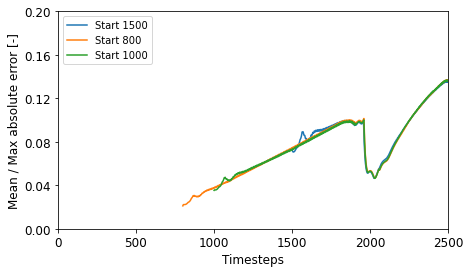

In [13]:
fig, ax = plt.subplots(figsize=(7,4))

ax.plot(list(range(1500,2501)),error_dict['FEM_1000_mean'],label=f'Start 1500')
ax.plot(list(range(800,2501)),error_dict['FEM_300_mean'],label=f'Start 800')
plt.plot(list(range(1000,2501)),error_dict['FEM_500_mean'],label=f'Start 1000')

ax.set_xlim(0,2500)
ax.set_ylim(0,0.2)
ax.yaxis.set_major_locator(MaxNLocator(6)) 
ax.legend(loc='upper left')
ax.set_ylabel('Mean / Max absolute error [-]',fontsize=12)
ax.set_xlabel('Timesteps',fontsize=12)
ax.tick_params(axis='both', labelsize=12)
plt.savefig('mean_error.png',dpi=600,bbox_inches='tight')

### Salvus plot Ricker function 

In [37]:
def Ricker(center_frequency,time_step_in_seconds,wavelet_width_in_seconds):

    time = np.linspace(
        -wavelet_width_in_seconds,
        wavelet_width_in_seconds,
        int((2 * wavelet_width_in_seconds / time_step_in_seconds)),
    )

    w_p = 2 * np.pi * center_frequency
    wavelet = ( 1 - 1/2 * w_p ** 2 * time ** 2 ) * np.exp( - (1/4) * w_p ** 2 * time ** 2 )

    return time, wavelet

In [122]:
def FrequencySpectrum(center_frequency):    
    freqs = np.linspace(0,4*center_frequency,100) #[Hz]

    r = (2 * (2 * np.pi * freqs) ** 2) / (np.sqrt(np.pi) * (2 * np.pi * center_frequency) ** 3) * np.exp(- freqs ** 2 / center_frequency ** 2)
    return freqs, r

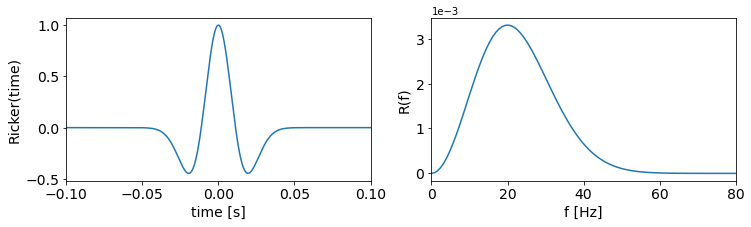

In [222]:
time, wavelet = Ricker(20,0.0002,0.1)
freqs, r = FrequencySpectrum(20)

fig, ax = plt.subplots(1,2,figsize=(12,3))
ax[0].plot(time, wavelet)
ax[0].set_xlabel("time [s]",fontsize=14)
ax[0].set_ylabel("Ricker(time)",fontsize=14)
ax[0].set_xlim(-0.1,0.1)
ax[0].tick_params(axis='both', labelsize=14)

ax[1].plot(freqs, r)
ax[1].set_xlabel("f [Hz]",fontsize=14)
ax[1].set_ylabel("R(f)",fontsize=14)
ax[1].set_xlim(0,4*20)
ax[1].tick_params(axis='both', labelsize=14)

plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#plt.savefig('ricker_20hz.png',dpi=600,bbox_inches='tight')